In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from glob import glob
import os
import imageio

from naiveclassifier import NaiveClassifier
from expertclassifier import ExpertClassifier
from utils import ImageStreamer, plot_cmatrix

traindatapath = 'train.csv'
cols = ['style', 'filename']
imgdir = r'D:\ArtStyle\Test'

data = pd.read_csv(traindatapath, header=0, names=cols)
data['filename'] = [os.path.join(imgdir, f) for f in data['filename'].values]

In [2]:
# Getting list of available data points (i.e. files downloaded to device and not filtered out and not in test set)
downloaded_fnames = glob(os.path.join(imgdir, '*.jpg'))  # files downloaded to computer
train_fnames = list(data['filename'].values)             # filenames in training split (downloaded or not)
train_styles = list(data['style'].values)
avail_fnames = [f for f in downloaded_fnames if f in train_fnames]  # downloaded filenames in training split
# avail_styles = [train_styles[train_fnames.index(f)] for f in avail_fnames]

print('{0} files available out of {1} files downloaded.'.format(len(avail_fnames), len(downloaded_fnames)))

17111 files available out of 23807 files downloaded.


In [3]:
# truncating data to images already downloaded - this reduces the available training/validation data
data = data.loc[data['filename'].isin(avail_fnames)]
display(data.iloc[:10])

# splitting training data into training and validation sets
validation_split = 0.1  # as a fraction of the training set
train_split = 1 - validation_split

data = data.sample(frac=1, random_state=0).reset_index(drop=True)

num_instances = len(data)
num_train = int(np.ceil(train_split * num_instances))
num_val = int(np.ceil(validation_split * num_train))

val = data.iloc[num_train:]
train = data.iloc[:num_train]

print('{0} instances in training.\n{1} instance in validation.'.format(len(train), len(val)))


,style,filename
6,Romanticism,D:\ArtStyle\Test\97897.jpg
10,Rococo,D:\ArtStyle\Test\40116.jpg
12,Art Nouveau (Modern),D:\ArtStyle\Test\39594.jpg
13,Surrealism,D:\ArtStyle\Test\72900.jpg
17,Expressionism,D:\ArtStyle\Test\97022.jpg
24,Naïve Art (Primitivism),D:\ArtStyle\Test\96265.jpg
38,Impressionism,D:\ArtStyle\Test\16007.jpg
40,Neoclassicism,D:\ArtStyle\Test\70066.jpg
47,Romanticism,D:\ArtStyle\Test\45332.jpg
49,Impressionism,D:\ArtStyle\Test\88162.jpg


15400 instances in training.
1711 instance in validation.


In [12]:
# Get styles in data, in alphabetical order
counts = data.groupby('style').count().add_suffix('_count').reset_index()
style_names = counts['style'].squeeze().values.copy()
style_names[11] = 'Primitivism'  # character issue in Naive art label
display(style_names)
display(counts)

array(['Abstract Expressionism', 'Art Informel', 'Art Nouveau (Modern)',
       'Baroque', 'Cubism', 'Early Renaissance', 'Expressionism',
       'High Renaissance', 'Impressionism', 'Magic Realism',
       'Mannerism (Late Renaissance)', 'Primitivism', 'Neoclassicism',
       'Northern Renaissance', 'Post-Impressionism', 'Realism', 'Rococo',
       'Romanticism', 'Surrealism', 'Symbolism', 'Ukiyo-e'], dtype=object)

,style,filename_count
0,Abstract Expressionism,481
1,Art Informel,257
2,Art Nouveau (Modern),1011
3,Baroque,1027
4,Cubism,391
5,Early Renaissance,274
6,Expressionism,1546
7,High Renaissance,239
8,Impressionism,2187
9,Magic Realism,276


# Naive Classifier

Training accuracy 0.12753246753246752
Validation accuracy 0.13033313851548803


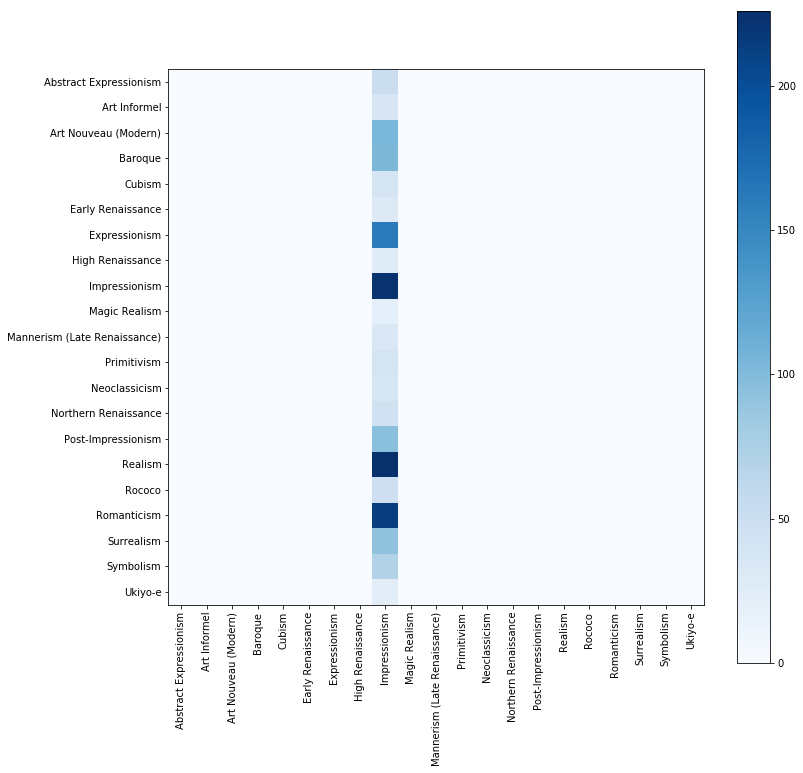

In [36]:
# Instantiate classifier and train
nc = NaiveClassifier()
nc.train(X=train['filename'].values, Y=train['style'].values)

# Evaluate on validation set
naive_acc, _ = nc.evaluate(X=train['filename'].values, Y=train['style'].values)
print('Training accuracy', naive_acc)
naive_acc, naive_pred = nc.evaluate(X=val['filename'].values, Y=val['style'].values)
print('Validation accuracy', naive_acc)

naive_cmatrix = confusion_matrix(val['style'].values, naive_pred, labels=counts['style'].values)
plt.figure(figsize=(12,12))
plot_cmatrix(naive_cmatrix, style_names)
np.savetxt('naive_cmatrix.csv', naive_cmatrix, fmt='%3d', delimiter=',')

# Expert Classifier

In [ ]:
human = pd.read_csv('human_raw.csv', header=0, usecols=[1,3,4,5,6])
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    cmatrix = confusion_matrix(human['Label'].values, human.iloc[:, i+1].values, labels=style_names)
    im = plot_cmatrix(cmatrix, cbar=False)
    plt.title(human.columns[i+1])

ticks = np.arange(len(style_names))
plt.subplot(2,2,1)
plt.yticks(ticks, style_names)
plt.subplot(2,2,3)
plt.yticks(ticks, style_names)
plt.xticks(ticks, style_names, rotation=90)
plt.subplot(2,2,4)
plt.xticks(ticks, style_names, rotation=90)

fig = plt.gcf()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()


In [ ]:
# Analyzing images to learn feature detectors by hand
plot=False
N = 50
stream = ImageStreamer(avail_fnames[:N])
ec = ExpertClassifier()
results = []
if plot:
    plt.figure(figsize=(24, int(np.ceil(N/4)) * 6))
# print('#\tstyle\t\t\tvar\tavg\tblur')
for i, im in enumerate(stream):
    if plot:
        plt.subplot(int(np.ceil(N/4)),4,i+1)
        plt.imshow(im)
        plt.title(avail_styles[i])
    results.append([avail_styles[i], ec.variance(im), ec.avg_color(im), ec.blurriness(im, 1.0)])
#     print('{0}\t{1:20s}\t{2:5.0f}\t{3:3.0f}\t{4:3.0f}'.format(i+1, avail_styles[i], ec.variance(im), ec.avg_color(im), ec.blurriness(im, 1.0)))
resdf = pd.DataFrame(results, columns=['style', 'var', 'avg', 'blur'])
display(resdf)
grouped = resdf.groupby('style')
if plot:
    plt.show()

In [90]:
desc = grouped.describe(percentiles=[])
# desc.to_csv('desc.csv')

In [6]:
# After feature detectors have been hand-designed, running them on a subset of training data
stream = ImageStreamer(val['filename'].values)
ec = ExpertClassifier()
acc, expert_pred = ec.evaluate(stream, val['style'].values)
print('Training accuracy', acc)

Training accuracy 0.146697837521917


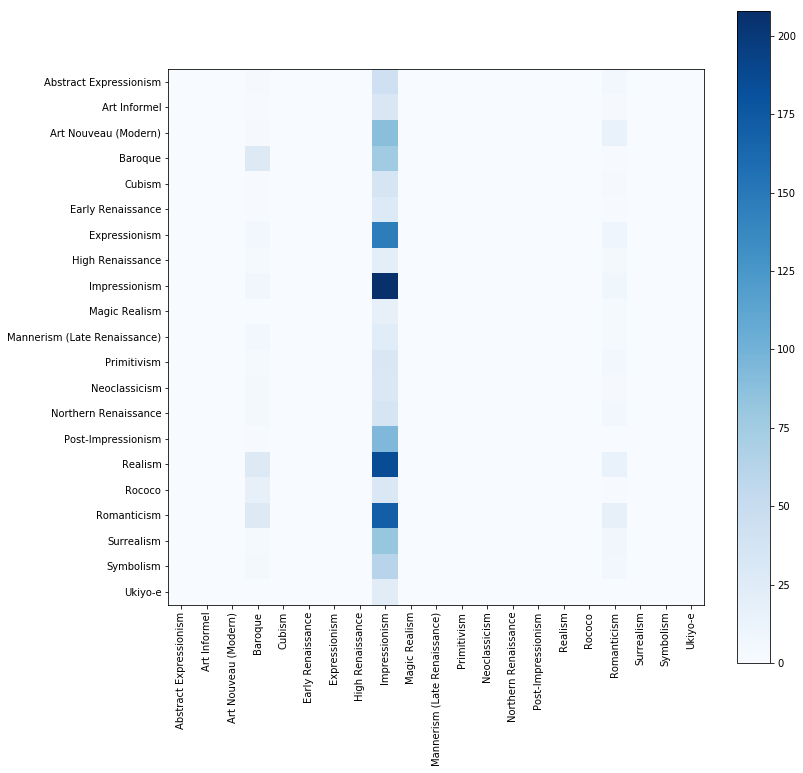

In [17]:
# Get confusion matrix
true_labels = val['style'].values
expert_cmatrix = confusion_matrix(true_labels, expert_pred, labels=counts['style'].values)
plt.figure(figsize=(12,12))
plot_cmatrix(expert_cmatrix, style_names)
np.savetxt('expert_cmatrix.csv', expert_cmatrix, fmt='%3d', delimiter=',')